<a href="https://colab.research.google.com/github/mmaruthi/S6-Assignment-Solution/blob/master/Trial-1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 5 

Targets:   
        Params should be less than 10k.
        Accuracy should be  greater than or equal to 99.4
       Increase model capacity and use Learning rate with StepLR
       
Results:
        Params - 7758    
        Best Train acc: 98.49
        Best Test acc : 99.40
        
Analysis:   
        Model reached an accuracy of 99.40
        Will try pushing further by using other Image augmentation techniques and cyclic LR etc.

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                       transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-13.0, 13.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# View the data 
View how the images are looking like


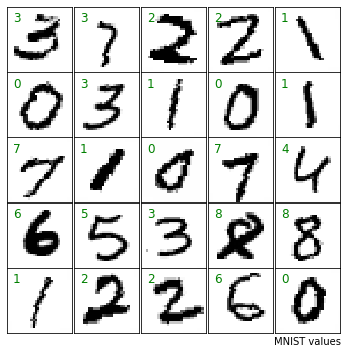

In [22]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

from matplotlib import pyplot as plt 
import matplotlib.gridspec as grid

%matplotlib inline
def viewMNIST(images, labels):
  r, c = 5, 5
  figmatrix = plt.figure(figsize=(6, 6))    # Each square size is of 6 * 6
  gs1 = grid.GridSpec(r, c)                 # No. of rows and columns in the grid 
  gs1.update(wspace=0.005, hspace=0.005)    # space to be left after each grid
  for i in range(1, r*c+1):                 # for loop 
    plt.subplot(gs1[i-1])
    plt.tick_params( axis='both', which='both', labelbottom=False, labelleft=False, left=False, bottom=False)
    plt.imshow(images[i-1].numpy().squeeze(), cmap='gray_r')
    plt.text(2, 6, labels[i-1].numpy(), color="green", fontsize="large")
  
  plt.xlabel("MNIST values")
  plt.show()

viewMNIST(images[:25], labels[:25])

# The model
Max pooling at RF = 5 + Batch Normalization + Dropout + GAP with architecture changes to reduce Params . Transforms also used.

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.Dropout(0.08),
            nn.ReLU()
        ) # output_size = 26, RF = 3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.Dropout(0.08),
            nn.ReLU()
        ) # output_size = 24  , RF = 5

                # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12 , RF = 6 

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.Dropout(0.08),
            nn.ReLU()
        ) # output_size = 10 , RF = 10 

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.Dropout(0.08),
            nn.ReLU()
        ) # output_size = 8 , RF = 14 

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.Dropout(0.08),
            nn.ReLU()
        ) # output_size = 6 , RF = 18 

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(0.08),
            nn.ReLU()
        ) # output_size = 6, RF = 22 

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(0.08),
            nn.ReLU()
        ) # output_size = 4, RF = 22 

        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=2)
        ) # output_size = 1 , RF = 28 

        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            #nn.BatchNorm2d(16), NEVER
            #nn.ReLU() NEVER!
        ) # output_size = 1 , RF = 28

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)
        x = self.convblock3(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.gap(x)
        x = self.convblock9(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [24]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
           Dropout-3           [-1, 10, 26, 26]               0
              ReLU-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 10, 24, 24]             900
       BatchNorm2d-6           [-1, 10, 24, 24]              20
           Dropout-7           [-1, 10, 24, 24]               0
              ReLU-8           [-1, 10, 24, 24]               0
         MaxPool2d-9           [-1, 10, 12, 12]               0
           Conv2d-10           [-1, 10, 10, 10]             900
      BatchNorm2d-11           [-1, 10, 10, 10]              20
          Dropout-12           [-1, 10, 10, 10]               0
             ReLU-13           [-1, 10, 10, 10]               0
           Conv2d-14             [

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Train and Test the model - Without L1 and L2 decay


In [26]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.9)
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.15617118775844574 Batch_id=468 Accuracy=90.12: 100%|██████████| 469/469 [00:22<00:00, 21.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0494, Accuracy: 9839/10000 (98.39%)

EPOCH: 1


Loss=0.04422162100672722 Batch_id=468 Accuracy=96.94: 100%|██████████| 469/469 [00:22<00:00, 21.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0366, Accuracy: 9886/10000 (98.86%)

EPOCH: 2


Loss=0.08373600989580154 Batch_id=468 Accuracy=97.41: 100%|██████████| 469/469 [00:22<00:00, 21.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0374, Accuracy: 9878/10000 (98.78%)

EPOCH: 3


Loss=0.10125996917486191 Batch_id=468 Accuracy=97.72: 100%|██████████| 469/469 [00:22<00:00, 21.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0329, Accuracy: 9904/10000 (99.04%)

EPOCH: 4


Loss=0.02176063321530819 Batch_id=468 Accuracy=97.80: 100%|██████████| 469/469 [00:22<00:00, 21.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0277, Accuracy: 9912/10000 (99.12%)

EPOCH: 5


Loss=0.0490947850048542 Batch_id=468 Accuracy=97.91: 100%|██████████| 469/469 [00:22<00:00, 21.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0305, Accuracy: 9911/10000 (99.11%)

EPOCH: 6


Loss=0.07979438453912735 Batch_id=468 Accuracy=98.04: 100%|██████████| 469/469 [00:22<00:00, 20.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0380, Accuracy: 9879/10000 (98.79%)

EPOCH: 7


Loss=0.04106837511062622 Batch_id=468 Accuracy=98.15: 100%|██████████| 469/469 [00:22<00:00, 20.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0265, Accuracy: 9913/10000 (99.13%)

EPOCH: 8


Loss=0.03554416075348854 Batch_id=468 Accuracy=98.23: 100%|██████████| 469/469 [00:22<00:00, 21.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Accuracy: 9926/10000 (99.26%)

EPOCH: 9


Loss=0.04218369349837303 Batch_id=468 Accuracy=98.24: 100%|██████████| 469/469 [00:21<00:00, 21.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0255, Accuracy: 9929/10000 (99.29%)

EPOCH: 10


Loss=0.0308239683508873 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:22<00:00, 21.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0265, Accuracy: 9924/10000 (99.24%)

EPOCH: 11


Loss=0.04030308499932289 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:22<00:00, 21.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0276, Accuracy: 9921/10000 (99.21%)

EPOCH: 12


Loss=0.026706306263804436 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:22<00:00, 20.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9929/10000 (99.29%)

EPOCH: 13


Loss=0.05604463815689087 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:22<00:00, 20.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0260, Accuracy: 9929/10000 (99.29%)

EPOCH: 14


Loss=0.023187806829810143 Batch_id=468 Accuracy=98.43: 100%|██████████| 469/469 [00:22<00:00, 25.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0240, Accuracy: 9930/10000 (99.30%)

EPOCH: 15


Loss=0.0870145857334137 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:22<00:00, 20.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0253, Accuracy: 9926/10000 (99.26%)

EPOCH: 16


Loss=0.057578813284635544 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:22<00:00, 20.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9937/10000 (99.37%)

EPOCH: 17


Loss=0.07905550301074982 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:22<00:00, 20.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9936/10000 (99.36%)

EPOCH: 18


Loss=0.05073525384068489 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:22<00:00, 21.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0254, Accuracy: 9930/10000 (99.30%)

EPOCH: 19


Loss=0.06318866461515427 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:22<00:00, 20.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0240, Accuracy: 9926/10000 (99.26%)

EPOCH: 20


Loss=0.03001703880727291 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:22<00:00, 20.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9941/10000 (99.41%)

EPOCH: 21


Loss=0.006131420377641916 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:22<00:00, 20.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9933/10000 (99.33%)

EPOCH: 22


Loss=0.022018611431121826 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:22<00:00, 21.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9934/10000 (99.34%)

EPOCH: 23


Loss=0.034923527389764786 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:22<00:00, 21.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9937/10000 (99.37%)

EPOCH: 24


Loss=0.01981058157980442 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:22<00:00, 21.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9941/10000 (99.41%)

EPOCH: 25


Loss=0.17475096881389618 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:22<00:00, 28.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9944/10000 (99.44%)

EPOCH: 26


Loss=0.034395020455121994 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:22<00:00, 26.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9944/10000 (99.44%)

EPOCH: 27


Loss=0.03920699656009674 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:22<00:00, 20.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9935/10000 (99.35%)

EPOCH: 28


Loss=0.013060316443443298 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:22<00:00, 20.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9938/10000 (99.38%)

EPOCH: 29


Loss=0.008743584156036377 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:22<00:00, 20.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9935/10000 (99.35%)

EPOCH: 30


Loss=0.008990774862468243 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:22<00:00, 20.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9933/10000 (99.33%)

EPOCH: 31


Loss=0.04942730441689491 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:22<00:00, 20.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9938/10000 (99.38%)

EPOCH: 32


Loss=0.025354212149977684 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:22<00:00, 20.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9939/10000 (99.39%)

EPOCH: 33


Loss=0.0032000690698623657 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:22<00:00, 20.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9946/10000 (99.46%)

EPOCH: 34


Loss=0.038710687309503555 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:22<00:00, 21.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9939/10000 (99.39%)

EPOCH: 35


Loss=0.036178916692733765 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:22<00:00, 21.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9936/10000 (99.36%)

EPOCH: 36


Loss=0.08763404935598373 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:22<00:00, 21.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9937/10000 (99.37%)

EPOCH: 37


Loss=0.04052203893661499 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:22<00:00, 21.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9938/10000 (99.38%)

EPOCH: 38


Loss=0.10122427344322205 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:22<00:00, 21.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9942/10000 (99.42%)

EPOCH: 39


Loss=0.11287436634302139 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:22<00:00, 21.22it/s]



Test set: Average loss: 0.0214, Accuracy: 9933/10000 (99.33%)

